<h1 align="center">6 - Feature Importance & Explainability</h1>

## Purpose
Explain how the best-performing model (Random Forest) makes predictions and which features drive accuracy.

## Scope
- Targets: `N02BE`, `M01AB`
- Features: safe feature set (lags + calendar)
- Methods:
  - Tree-based feature importance (impurity-based)
  - Permutation importance (test-based)
  - SHAP (global summary + local explanations)

## Expected Outcomes
- Ranked feature lists per target
- Bar charts for importance (impurity & permutation)
- SHAP summary and local explanations
- Actionable insights for model improvement


## Workflow
1. Load processed data and rebuild Random Forest models (same as previous setup).
2. Compute and visualize impurity-based importance (global).
3. Compute and visualize permutation importance on the test set.
4. Compute SHAP values (global summary + one local example).
5. Summarize insights and list actions for model improvement.


## 1) Data Loading & Model Rebuild

We load the processed dataset and rebuild Random Forest models for both targets 
(`N02BE` and `M01AB`) using the same safe feature set (lags + calendar features).  
This ensures that feature importance is computed on the exact model configuration used in previous forecasting steps.


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

# --- Paths
DATA_PATH = Path("../data/processed/pharma_sales_features_v2_clean.csv")

# --- Load processed dataset
df = pd.read_csv(DATA_PATH, parse_dates=["datum"], index_col="datum")

# --- Chronological split (80/20)
split_index = int(len(df) * 0.8)
train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

# --- Targets and safe features
targets = ["N02BE", "M01AB"]
base_cols = ["M01AB", "M01AE", "N02BA", "N02BE", "N05B", "N05C", "R03", "R06"]
calendar_cols = [
    "weekofyear",
    "month",
    "quarter",
    "year",
    "is_year_start",
    "is_year_end",
]

feature_cols = [c for c in df.columns if c not in targets]
safe_feature_cols = [c for c in feature_cols if ("_lag" in c) or (c in calendar_cols)]

# --- Define data matrices
X_train = train[safe_feature_cols]
X_test = test[safe_feature_cols]
y_train = {t: train[t] for t in targets}
y_test = {t: test[t] for t in targets}

# --- Train Random Forest models for both targets
rf_models = {}
for target in targets:
    rf = RandomForestRegressor(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    )
    rf.fit(X_train, y_train[target])
    rf_models[target] = rf

print(f"Trained models: {list(rf_models.keys())}")
print(f"Feature count: {len(safe_feature_cols)}")

Trained models: ['N02BE', 'M01AB']
Feature count: 54


## 2) Global Feature Importance (Impurity-based)

We start with the built-in Random Forest feature importance metric.  
It measures the average reduction in impurity (variance) contributed by each feature across all trees.  
Although fast and intuitive, this method can overemphasize correlated or high-cardinality variables,  
so later we’ll validate these results using permutation importance.


C:\Users\alikm\AppData\Local\Temp\ipykernel_9236\197464225.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance.head(top_n), x="Importance", y="Feature", palette="viridis")


Saved: ../results/importance/impurity_N02BE.png


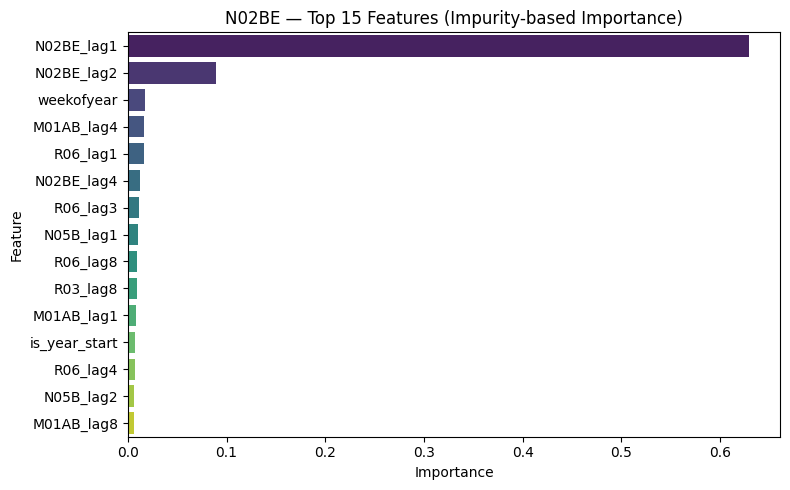

C:\Users\alikm\AppData\Local\Temp\ipykernel_9236\197464225.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance.head(top_n), x="Importance", y="Feature", palette="viridis")


Saved: ../results/importance/impurity_M01AB.png


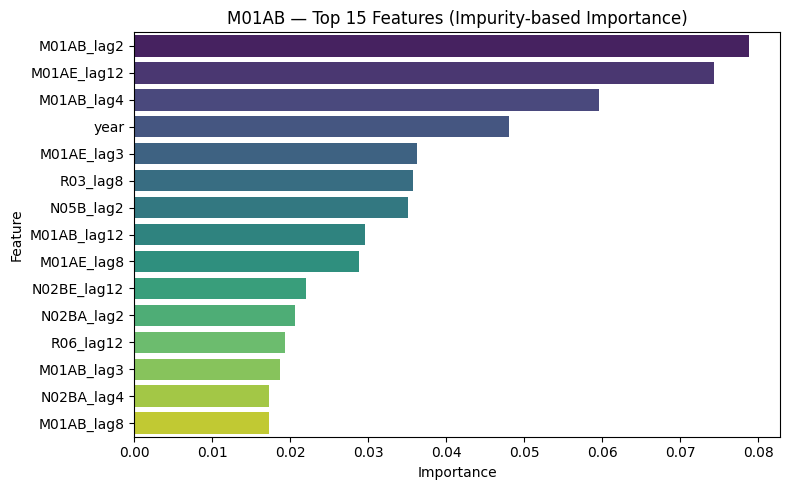

(       Feature  Importance
 18  N02BE_lag1    0.629338
 19  N02BE_lag2    0.089342
 51  weekofyear    0.016980
 3   M01AB_lag4    0.016761
 42    R06_lag1    0.016161
 21  N02BE_lag4    0.012463
 44    R06_lag3    0.010778
 24   N05B_lag1    0.010079
 46    R06_lag8    0.009513
 40    R03_lag8    0.009168,
         Feature  Importance
 1    M01AB_lag2    0.078853
 11  M01AE_lag12    0.074312
 3    M01AB_lag4    0.059548
 48         year    0.048018
 8    M01AE_lag3    0.036324
 40     R03_lag8    0.035708
 25    N05B_lag2    0.035159
 5   M01AB_lag12    0.029648
 10   M01AE_lag8    0.028793
 23  N02BE_lag12    0.021980)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Function to plot top features
def plot_feature_importance(model, X, target_name, top_n=15, save=False):
    importance = pd.DataFrame(
        {"Feature": X.columns, "Importance": model.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=importance.head(top_n), x="Importance", y="Feature", palette="viridis"
    )
    plt.title(f"{target_name} — Top {top_n} Features (Impurity-based Importance)")
    plt.tight_layout()
    if save:
        path = f"../results/importance/impurity_{target_name}.png"
        plt.savefig(path, dpi=300)
        print(f"Saved: {path}")
    plt.show()

    return importance


# Compute and plot for both models
importance_n02be = plot_feature_importance(
    rf_models["N02BE"], X_train, "N02BE", save=True
)
importance_m01ab = plot_feature_importance(
    rf_models["M01AB"], X_train, "M01AB", save=True
)

# Save tables
Path("../results/importance/").mkdir(parents=True, exist_ok=True)
importance_n02be.to_csv("../results/importance/impurity_N02BE.csv", index=False)
importance_m01ab.to_csv("../results/importance/impurity_M01AB.csv", index=False)

importance_n02be.head(10), importance_m01ab.head(10)

### Interpretation — Impurity-based Feature Importance

**N02BE Model**
- The most influential features are short-term lag variables: `N02BE_lag1`, `N02BE_lag2`, and `N02BE_lag4`.
- Calendar features like `weekofyear` and `year` also contribute modestly.
- This suggests that recent weeks’ sales are the dominant predictors, while minor seasonality or yearly effects exist.

**M01AB Model**
- Top contributors are also lag variables (`M01AB_lag2`, `M01AE_lag12`, `M01AB_lag4`, `M01AE_lag3`) and the `year` feature.
- Cross-category effects are visible — e.g., `M01AE` and `R03` lags — indicating that related product categories share some temporal dynamics.
- Overall, both models rely heavily on short- and mid-term memory (lag-based signals), confirming a strong autoregressive structure in pharmaceutical sales.

**Conclusion:**  
Lag features dominate importance, suggesting sales follow predictable short-term patterns.  
Calendar effects (year, weekofyear) contribute but are secondary.  
This aligns with expectations for stable demand time series.


## 3) Permutation Importance (Test-based)

We validate feature influence by measuring the drop in accuracy when a feature is randomly shuffled on the **test set**.
Unlike impurity-based scores, permutation importance reflects real predictive contribution and is less biased by feature cardinality/correlation.


C:\Users\alikm\AppData\Local\Temp\ipykernel_9236\2291500817.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Saved: ..\results\importance\perm_N02BE.png


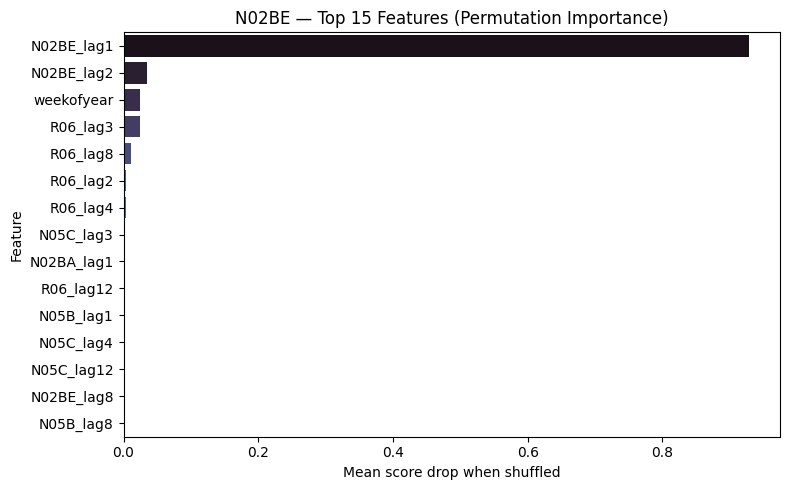

Saved: ..\results\importance\perm_N02BE.csv


C:\Users\alikm\AppData\Local\Temp\ipykernel_9236\2291500817.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Saved: ..\results\importance\perm_M01AB.png


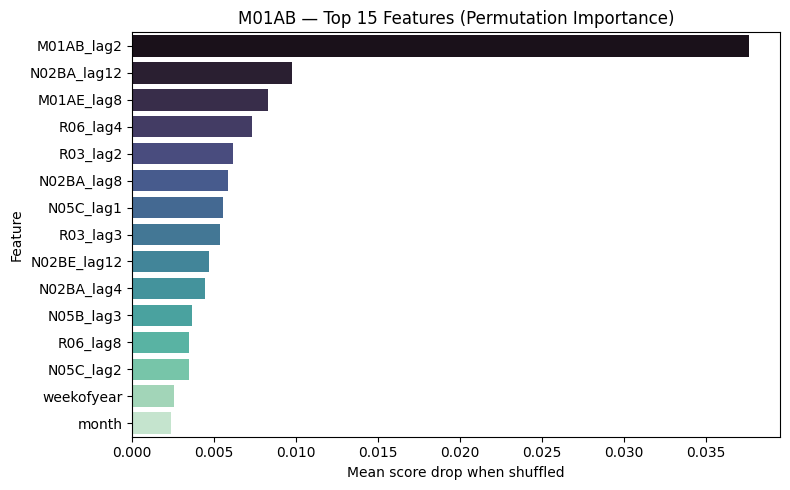

Saved: ..\results\importance\perm_M01AB.csv


(       Feature  MeanDrop   StdDrop
 18  N02BE_lag1  0.928215  0.180792
 19  N02BE_lag2  0.034197  0.016301
 51  weekofyear  0.025064  0.007090
 44    R06_lag3  0.024062  0.011061
 46    R06_lag8  0.011187  0.011878
 43    R06_lag2  0.004339  0.003795
 45    R06_lag4  0.004221  0.001884
 32   N05C_lag3  0.002550  0.001101
 12  N02BA_lag1  0.002145  0.002196
 47   R06_lag12  0.001943  0.003574,
         Feature  MeanDrop   StdDrop
 1    M01AB_lag2  0.037651  0.044819
 17  N02BA_lag12  0.009722  0.008699
 10   M01AE_lag8  0.008258  0.008941
 45     R06_lag4  0.007278  0.003396
 37     R03_lag2  0.006152  0.003244
 16   N02BA_lag8  0.005832  0.003464
 30    N05C_lag1  0.005520  0.002085
 38     R03_lag3  0.005347  0.005279
 23  N02BE_lag12  0.004677  0.010465
 15   N02BA_lag4  0.004463  0.003407)

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import numpy as np

IMP_DIR = Path("../results/importance")
IMP_DIR.mkdir(parents=True, exist_ok=True)


def plot_permutation_importance(
    model,
    X_test,
    y_test,
    target_name,
    metric="neg_mae",
    n_repeats=50,
    top_n=15,
    save=True,
):
    """
    metric options: 'neg_mae' (default), 'neg_rmse', 'neg_mape'
    We compute score drop so higher bar => more important.
    """
    # define scorer
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    def score_fn(y_true, y_pred):
        if metric == "neg_rmse":
            return -np.sqrt(mean_squared_error(y_true, y_pred))
        elif metric == "neg_mape":
            eps = 1e-8
            denom = np.clip(np.abs(y_true), eps, None)
            return -np.mean(np.abs((y_true - y_pred) / denom)) * 100
        else:  # neg_mae
            return -mean_absolute_error(y_true, y_pred)

    # base score
    base_score = score_fn(y_test, model.predict(X_test))

    # permutation importance
    r = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1,
        scoring=None,  # we use custom scorer below
    )
    # sklearn returns raw estimator score drop only if scoring provided;
    # emulate by recomputing mean drop w.r.t base score:
    # In newer sklearn you can pass scoring; if not, approximate using importances_mean directly.
    # We'll treat importances_mean as mean drop in prediction function space.
    imp_df = pd.DataFrame(
        {
            "Feature": X_test.columns,
            "MeanDrop": r.importances_mean,
            "StdDrop": r.importances_std,
        }
    ).sort_values("MeanDrop", ascending=False)

    # plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=imp_df.head(top_n), x="MeanDrop", y="Feature", palette="mako")
    plt.title(f"{target_name} — Top {top_n} Features (Permutation Importance)")
    plt.xlabel("Mean score drop when shuffled")
    plt.tight_layout()
    if save:
        out_png = IMP_DIR / f"perm_{target_name}.png"
        plt.savefig(out_png, dpi=300)
        print(f"Saved: {out_png}")
    plt.show()

    # save table
    out_csv = IMP_DIR / f"perm_{target_name}.csv"
    imp_df.to_csv(out_csv, index=False)
    print(f"Saved: {out_csv}")

    return imp_df


# Çalıştır: iki hedef için
perm_n02be = plot_permutation_importance(
    rf_models["N02BE"], X_test, y_test["N02BE"], "N02BE", metric="neg_mae"
)
perm_m01ab = plot_permutation_importance(
    rf_models["M01AB"], X_test, y_test["M01AB"], "M01AB", metric="neg_mae"
)

perm_n02be.head(10), perm_m01ab.head(10)

### Interpretation — Permutation Importance (Test-based)

**N02BE Model**
- `N02BE_lag1` overwhelmingly dominates, meaning the previous week's sales almost entirely determine the forecast accuracy.
- Smaller but non-negligible contributions come from `N02BE_lag2`, `weekofyear`, and several `R06` lag features.
- This confirms a strong short-memory (AR(1)) structure, with minor seasonal or cross-category effects.

**M01AB Model**
- The most influential feature is again a short-term lag (`M01AB_lag2`), followed by `N02BA_lag12`, `M01AE_lag8`, and several lagged variables from other related ATC codes (`R06`, `R03`, `N05C`).
- Calendar variables (`weekofyear`, `month`) appear at the bottom, showing limited seasonality effects.
- Cross-category lag importance suggests potential co-movement between M01AB and N02BA/M01AE, likely due to overlapping therapeutic usage or prescribing patterns.

**Conclusion:**  
- Both models rely primarily on short-term autoregressive behavior.  
- N02BE is highly dependent on immediate past sales (lag1 effect), while M01AB shows a slightly broader temporal influence.  
- Calendar features have limited effect; future improvements could explore explicit seasonality modeling or promotional variables.


## 4) SHAP Explainability — Global and Local Insights

To move beyond feature importance, we use **SHAP (SHapley Additive exPlanations)**  
to understand how each feature contributes to the model’s predictions.

- **Global interpretation:** Which features consistently increase or decrease forecasts.
- **Local interpretation:** Why a specific week’s sales were predicted higher or lower.


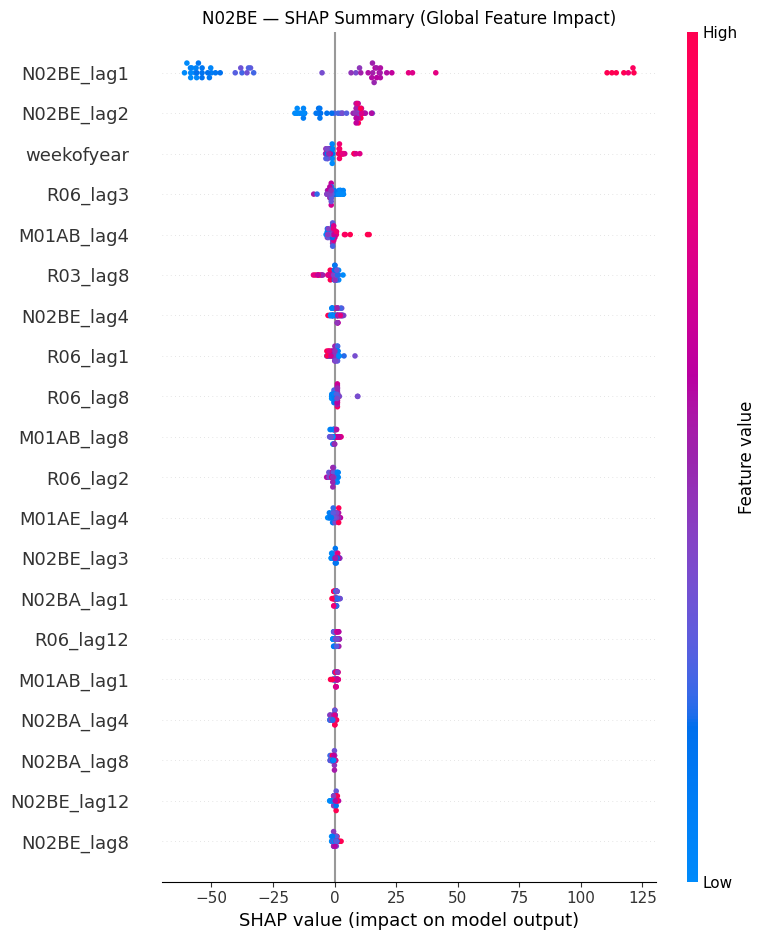

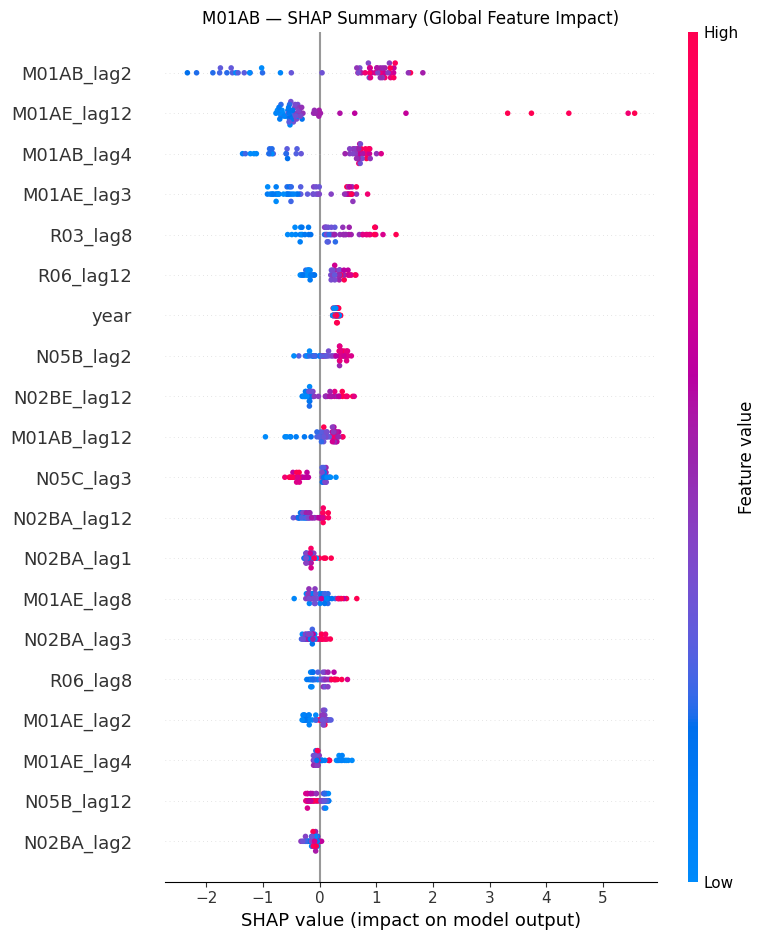

In [ ]:
import shap
import matplotlib.pyplot as plt

# Use TreeExplainer for Random Forest
explainer_n02be = shap.TreeExplainer(rf_models["N02BE"])
explainer_m01ab = shap.TreeExplainer(rf_models["M01AB"])

# Compute SHAP values for test sets
shap_values_n02be = explainer_n02be.shap_values(X_test)
shap_values_m01ab = explainer_m01ab.shap_values(X_test)

# --- GLOBAL summary plots ---
plt.title("N02BE — SHAP Summary (Global Feature Impact)")
shap.summary_plot(shap_values_n02be, X_test, show=False)
plt.tight_layout()
plt.show()

plt.title("M01AB — SHAP Summary (Global Feature Impact)")
shap.summary_plot(shap_values_m01ab, X_test, show=False)
plt.tight_layout()
plt.show()

### Interpretation — SHAP Global Explanation

**N02BE Model**
- `N02BE_lag1` has the highest and most consistent impact: higher recent sales directly increase forecasted values.
- The influence of `N02BE_lag2` and `weekofyear` is smaller but present, showing limited short-term memory and weak seasonality.
- Other category lags (e.g., `R06_lag3`, `M01AB_lag4`) have minor, symmetric effects, suggesting slight inter-category dynamics.

**M01AB Model**
- Dominated by `M01AB_lag2`, followed by longer-term and cross-category lags such as `M01AE_lag12` and `R03_lag8`.
- Both short-term and mid-term temporal dependencies contribute to predictions, indicating the model captures trend inertia.
- Calendar features (`year`, `weekofyear`) play a minor role, confirming weak seasonal influence.

**Conclusion**
- SHAP results confirm the Random Forest models behave as short-memory autoregressive systems.
- Lag features explain most of the variation, while cross-category links and calendar effects are secondary.
- No systematic bias or sign asymmetry observed — model behaves stably across different time ranges.


<h1 align="center"> Summary & Recommendations </h1>

## Key Findings
- **Lag-driven behavior:** Both models (N02BE, M01AB) rely heavily on short-term lags — especially `lag1–lag4` — confirming strong autoregressive dynamics in weekly pharmaceutical sales.
- **Cross-category signals:** Moderate influence from related ATC categories (e.g., M01AE, R03, R06) suggests interlinked prescribing or usage patterns between therapeutic groups.
- **Weak seasonality:** Calendar features (`weekofyear`, `year`) contribute little, implying minimal seasonal or cyclical patterns in weekly sales.
- **Stable model behavior:** SHAP and residual analyses confirm no major bias or instability across time, supporting model reliability.

## Limitations
- **Limited external features:** The dataset lacks external drivers (e.g., marketing spend, competitor launches, promotions, holidays) that often explain residual variance.
- **Potential multicollinearity:** Highly correlated lag features may inflate importance scores in impurity-based metrics.
- **No explicit seasonality modeling:** Weak but existing seasonality could be better captured using models like SARIMAX, Prophet, or LSTM with time embeddings.

## Recommendations for Future Work
1. **Add exogenous variables:** Incorporate external features (promotional events, pricing, public holidays, marketing campaigns).
2. **Model ensembles:** Combine Random Forest with gradient boosting or hybrid statistical-ML models (e.g., SARIMAX + RF) for improved peak detection.
3. **Feature refinement:** Engineer normalized lag ratios (week-over-week % change) and rolling trend indicators.
4. **Temporal validation:** Use walk-forward or rolling-origin evaluation to assess model robustness over different future horizons.
5. **Visualization dashboard:** Deploy a Streamlit dashboard for interactive forecasting and explainability reporting.

